<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [289]:
# librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
from scipy.stats import bernoulli, beta   
from math import lgamma

import pylab as plt

In [290]:
# datos
game = pd.read_csv('data/cookie_cats.csv')


In [291]:
game.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [292]:
game.shape

(90189, 5)

In [293]:
(game['version'] == 'gate_30').value_counts() # tipos de gates

False    45489
True     44700
Name: version, dtype: int64

In [294]:
# transformacion

game_filtrado301 = game.loc[(game['version'] == 'gate_30') & (game['retention_1'] == True), :]

game_filtrado301



,userid,version,sum_gamerounds,retention_1,retention_7
1,337,gate_30,38,True,False
13,2179,gate_30,39,True,False
14,2218,gate_30,305,True,True
15,2382,gate_30,73,True,False
16,2392,gate_30,14,True,False
...,...,...,...,...,...
90164,9996750,gate_30,48,True,False
90171,9997757,gate_30,84,True,False
90179,9998576,gate_30,14,True,False
90182,9999178,gate_30,21,True,False


In [295]:
game_filtrado307 = game.loc[(game['version'] == 'gate_30') & (game['retention_7'] == True), :]
game_filtrado307

,userid,version,sum_gamerounds,retention_1,retention_7
14,2218,gate_30,305,True,True
17,2451,gate_30,204,True,True
18,2482,gate_30,108,True,True
23,2729,gate_30,105,False,True
45,4929,gate_30,386,True,True
...,...,...,...,...,...
90121,9991145,gate_30,328,True,True
90127,9991540,gate_30,117,True,True
90134,9991949,gate_30,191,True,True
90163,9996688,gate_30,83,True,True


In [296]:
game_filtrado401 = game.loc[(game['version'] == 'gate_40') & (game['retention_1'] == True), :]
game_filtrado401

,userid,version,sum_gamerounds,retention_1,retention_7
2,377,gate_40,165,True,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False
...,...,...,...,...,...
90150,9995412,gate_40,253,True,True
90159,9996209,gate_40,40,True,False
90181,9998733,gate_40,10,True,False
90184,9999441,gate_40,97,True,False


In [297]:
game_filtrado407 = game.loc[(game['version'] == 'gate_40') & (game['retention_7'] == True), :]
game_filtrado407

,userid,version,sum_gamerounds,retention_1,retention_7
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
8,1574,gate_40,108,True,True
10,1842,gate_40,3,False,True
27,3132,gate_40,80,True,True
...,...,...,...,...,...
90059,9985460,gate_40,81,True,True
90115,9990636,gate_40,569,True,True
90125,9991408,gate_40,186,True,True
90150,9995412,gate_40,253,True,True


In [298]:
#testeo para retencion_1
dia1 = pd.crosstab(game['version'],game['retention_1'])
dia1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [299]:

imps_ctrl, convs_ctrl = 44700, 20034    

imps_test, convs_test = 45489, 20119


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Gate301: {CR_ctrl}, Gate401: {CR_test}'


'Tasas conversion: Gate301: 0.4481879194630872, Gate401: 0.44228274967574577'

In [300]:

# a priori


a_C  = 1+convs_ctrl             
b_C = 1+imps_ctrl-convs_ctrl    

a_T = 1+convs_test              
b_T = 1+imps_test-convs_test    

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [301]:
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)


def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d
        
        
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))



def calc_prob(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])
    
    

def pico(a, b):
    return (a-1)/(a+b-2)



def plot(betas, names, linf=0.42, lsup=0.47):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
        plt.legend()
plt.show();


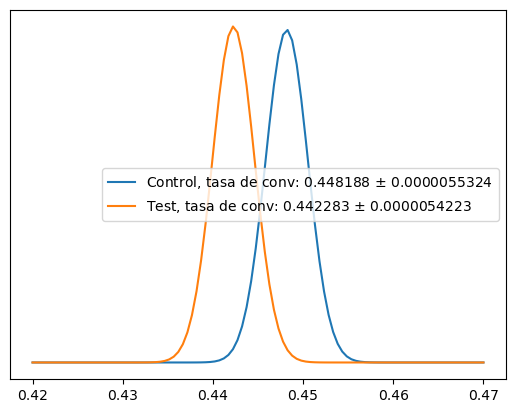

In [302]:
plot([beta_control, beta_test],['Control', 'Test'])

In [303]:
#testeo para retencion_7
dia7 = pd.crosstab(game['version'],game['retention_7'])
dia7

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [304]:
imps_ctrl, convs_ctrl = 44700, 8502  

imps_test, convs_test = 45489, 8279


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Gate307: {CR_ctrl}, Gate407: {CR_test}'


'Tasas conversion: Gate307: 0.19020134228187918, Gate407: 0.18200004396667327'

In [305]:
# a priori


a_C  = 1+convs_ctrl             
b_C = 1+imps_ctrl-convs_ctrl    

a_T = 1+convs_test              
b_T = 1+imps_test-convs_test    

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [306]:
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)


def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d
        
        
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))



def calc_prob(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])
    
    

def pico(a, b):
    return (a-1)/(a+b-2)



def plot(betas, names, linf=0.170, lsup=0.200):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
        plt.legend()
    plt.show();

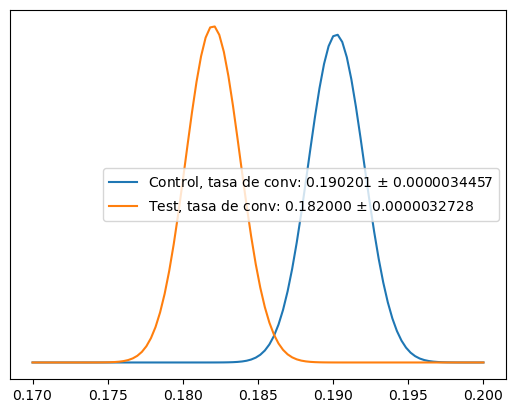

In [307]:
plot([beta_control, beta_test],['Control', 'Test'])

In [308]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.
# Como se puede observar en ambas curvas es que la nueva opción de las 40 semans para convertir de pago el juego es más ineficiente tanto en el primer día como en el 7
# por lo tanto, se mantiene la operativa del juego a 30 semanas, ya que el objetivo era el contrario.